<a href="https://colab.research.google.com/github/ciciwu/DNN-playground/blob/master/transfer_learning_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import torch
import torch.nn as nn
from torch.optim  import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models,transforms
import matplotlib.pyplot  as plt
import time
import os
import copy



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
mean=np.array([0.485,0.456,0.406])
std=np.array([0.229,0.224,0.225])


In [5]:
data_transforms={
    'train': transforms.Compose([
        #why resized crop?
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ])

}

In [38]:

!rm -r data/val/.ipynb_checkpoints

In [20]:
data_dir = 'data'
sets =['train','val']


In [39]:
!ls -a data/train/bees

.  ..  16838648_415acd9e3f.jpg	21399619_3e61e5bb6f.jpg


In [40]:
image_datasets={x: datasets.ImageFolder(os.path.join(data_dir,x),
                                        data_transforms[x]) for x in ['train', 'val']}

In [41]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [42]:
class_names

['ants', 'bees']

In [44]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

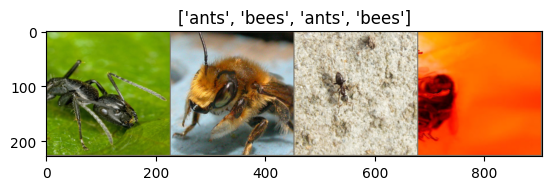

In [62]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [57]:
torchvision.utils.make_grid(inputs).shape

torch.Size([3, 228, 906])

In [51]:
inputs.shape

torch.Size([4, 3, 224, 224])

In [58]:
torchvision.utils.make_grid(inputs).numpy().transpose((1, 2, 0)).shape

(228, 906, 3)

In [50]:
inputs[0].shape

torch.Size([3, 224, 224])

In [63]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [64]:
model=models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [65]:
num_ftrs=model.fc.in_features

In [67]:
model.fc = nn.Linear(num_ftrs,2)

In [68]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [69]:
criterion = nn.CrossEntropyLoss()

In [70]:
from torch import optim
optimizer = optim.SGD(model.parameters(), lr=0.001)


In [71]:
step_lr_scheduler=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

In [72]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6569 Acc: 0.7500
val Loss: 0.8298 Acc: 0.2500

Epoch 1/24
----------
train Loss: 0.6705 Acc: 0.7500
val Loss: 0.8189 Acc: 0.2500

Epoch 2/24
----------
train Loss: 0.6920 Acc: 0.5000
val Loss: 0.8101 Acc: 0.2500

Epoch 3/24
----------
train Loss: 0.5510 Acc: 1.0000
val Loss: 0.7849 Acc: 0.2500

Epoch 4/24
----------
train Loss: 0.5915 Acc: 1.0000
val Loss: 0.7747 Acc: 0.2500

Epoch 5/24
----------
train Loss: 0.5539 Acc: 0.7500
val Loss: 0.7824 Acc: 0.2500

Epoch 6/24
----------
train Loss: 0.5711 Acc: 1.0000
val Loss: 0.7782 Acc: 0.5000

Epoch 7/24
----------
train Loss: 0.4756 Acc: 1.0000
val Loss: 0.7807 Acc: 0.5000

Epoch 8/24
----------
train Loss: 0.4673 Acc: 1.0000
val Loss: 0.7694 Acc: 0.5000

Epoch 9/24
----------
train Loss: 0.4600 Acc: 1.0000
val Loss: 0.7608 Acc: 0.5000

Epoch 10/24
----------
train Loss: 0.4645 Acc: 1.0000
val Loss: 0.7657 Acc: 0.5000

Epoch 11/24
----------
train Loss: 0.5598 Acc: 0.7500
val Loss: 0.7545 Acc: 0.5000

Ep

In [79]:
model.layer4[0].conv2.weight

Parameter containing:
tensor([[[[ 1.6042e-04, -1.4721e-02, -1.6999e-02],
          [-1.2852e-02, -3.3086e-02, -3.6652e-02],
          [ 2.7788e-02,  1.7673e-02, -1.8370e-02]],

         [[ 1.0534e-02,  3.1365e-02,  2.4778e-02],
          [-1.2696e-02, -2.9478e-02, -1.1840e-02],
          [-9.4161e-03, -8.9542e-03, -3.1352e-02]],

         [[-7.8273e-03, -2.9236e-02,  5.3681e-03],
          [-1.3786e-02, -1.1124e-02,  5.0303e-03],
          [-2.4923e-03,  7.3450e-03,  5.4004e-03]],

         ...,

         [[-1.0415e-03, -1.0282e-02, -2.9994e-02],
          [-3.8490e-03,  1.9380e-03, -1.6306e-02],
          [-1.8111e-03,  8.3748e-03, -8.5526e-03]],

         [[-1.8195e-02, -1.3537e-02, -1.7468e-02],
          [ 2.2467e-02,  5.7411e-02,  1.9319e-02],
          [-2.4977e-02, -3.2109e-02, -8.1729e-03]],

         [[ 3.6619e-03,  4.9379e-03, -5.7606e-03],
          [-1.6888e-02,  1.3550e-04,  3.6882e-04],
          [-2.6444e-03,  1.0763e-03,  1.1091e-03]]],


        [[[ 1.4016e-02,  3.9185

In [84]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [85]:
model_conv.layer4[0].conv2.weight[0]

tensor([[[ 0.0002, -0.0147, -0.0170],
         [-0.0129, -0.0331, -0.0367],
         [ 0.0278,  0.0177, -0.0184]],

        [[ 0.0105,  0.0314,  0.0248],
         [-0.0127, -0.0295, -0.0118],
         [-0.0094, -0.0089, -0.0313]],

        [[-0.0078, -0.0293,  0.0054],
         [-0.0138, -0.0111,  0.0050],
         [-0.0025,  0.0074,  0.0054]],

        ...,

        [[-0.0010, -0.0103, -0.0300],
         [-0.0038,  0.0020, -0.0163],
         [-0.0018,  0.0084, -0.0085]],

        [[-0.0182, -0.0135, -0.0175],
         [ 0.0225,  0.0574,  0.0193],
         [-0.0250, -0.0321, -0.0082]],

        [[ 0.0037,  0.0049, -0.0058],
         [-0.0169,  0.0001,  0.0004],
         [-0.0026,  0.0011,  0.0011]]])

In [86]:

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7602 Acc: 0.5000
val Loss: 0.6334 Acc: 0.5000

Epoch 1/24
----------
train Loss: 0.4392 Acc: 1.0000
val Loss: 0.6327 Acc: 0.5000

Epoch 2/24
----------
train Loss: 0.6517 Acc: 0.7500
val Loss: 0.6343 Acc: 0.5000

Epoch 3/24
----------
train Loss: 0.5027 Acc: 1.0000
val Loss: 0.6209 Acc: 0.5000

Epoch 4/24
----------
train Loss: 0.4034 Acc: 0.7500
val Loss: 0.6242 Acc: 0.5000

Epoch 5/24
----------
train Loss: 0.3956 Acc: 1.0000
val Loss: 0.6230 Acc: 0.5000

Epoch 6/24
----------
train Loss: 0.3581 Acc: 1.0000
val Loss: 0.6013 Acc: 0.5000

Epoch 7/24
----------
train Loss: 0.2972 Acc: 1.0000
val Loss: 0.6112 Acc: 0.5000

Epoch 8/24
----------
train Loss: 0.3580 Acc: 1.0000
val Loss: 0.6213 Acc: 0.7500

Epoch 9/24
----------
train Loss: 0.2569 Acc: 1.0000
val Loss: 0.6165 Acc: 0.7500

Epoch 10/24
----------
train Loss: 0.3991 Acc: 1.0000
val Loss: 0.6101 Acc: 0.7500

Epoch 11/24
----------
train Loss: 0.3436 Acc: 1.0000
val Loss: 0.6191 Acc: 0.7500

Ep

In [87]:
model_conv.layer4[0].conv2.weight[0]

tensor([[[ 0.0002, -0.0147, -0.0170],
         [-0.0129, -0.0331, -0.0367],
         [ 0.0278,  0.0177, -0.0184]],

        [[ 0.0105,  0.0314,  0.0248],
         [-0.0127, -0.0295, -0.0118],
         [-0.0094, -0.0089, -0.0313]],

        [[-0.0078, -0.0293,  0.0054],
         [-0.0138, -0.0111,  0.0050],
         [-0.0025,  0.0074,  0.0054]],

        ...,

        [[-0.0010, -0.0103, -0.0300],
         [-0.0038,  0.0020, -0.0163],
         [-0.0018,  0.0084, -0.0085]],

        [[-0.0182, -0.0135, -0.0175],
         [ 0.0225,  0.0574,  0.0193],
         [-0.0250, -0.0321, -0.0082]],

        [[ 0.0037,  0.0049, -0.0058],
         [-0.0169,  0.0001,  0.0004],
         [-0.0026,  0.0011,  0.0011]]])